# Convolutional Neural Networks (CNNs) with PyTorch

In this notebook, we explore the workings of Convolutional Neural Networks (CNNs) using PyTorch. CNNs are a type of neural network specifically designed for processing grid-like data, such as images.

We will:
- **Implement a simple CNN using PyTorch to understand the underlying operations.**
- Build a CNN from scratch using PyTorch.
- Understand the components of CNNs, including convolutional layers, pooling layers, and activation functions.
- Visualize feature maps to gain insight into the network's operation.
- **Visualize what the neural network is learning at each layer to understand patterns like vertical, horizontal, and diagonal edges.**

In [25]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from os.path import isfile, isdir, dirname
from os import mkdir
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import cupy as cnp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
SAVE_PATH = "./dump/model - fashion.pth"
SAVE_PATH_DIRECTORY = dirname(SAVE_PATH)
EPOCHS = 12
# This code sets up libraries for working with CNNs, datasets, and visualization.

## Dataset Preparation

We use the CIFAR-10 dataset, a widely-used dataset of 60,000 32x32 color images in 10 classes. The dataset is divided into 50,000 training images and 10,000 test images.

### Additional Insight:

- **CIFAR-10 Classes**: The dataset includes airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.
- **Data Normalization**: Normalizing data helps in faster convergence during training.

In [26]:
# from datasets import load_dataset

# # the data is already normalized and ladled
# tiny_imagenet = load_dataset('Maysee/tiny-imagenet')
# dataset_split = tiny_imagenet['train'].train_test_split(test_size=0.2) 
# train_dataset = dataset_split['train']
# test_dataset = dataset_split['test']

In [27]:
# # load the dataset
# import os 
# import cv2

# class_names_translation = {}
# IMAGE_SIZE = (150, 150)

# def load(folder_path):
#     data = []
#     labels = []
#     for i, classification_folder in enumerate(os.listdir(folder_path)):
#         class_names_translation[i] = classification_folder
#         print(classification_folder, i)
#         for image in os.listdir(f"{folder_path}\\{classification_folder}"):
#             image = cv2.imread(f"{folder_path}\\{classification_folder}\\{image}")
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             image = cv2.resize(image, IMAGE_SIZE) # resize 
#             data.append(image)
#             labels.append(i)
            
#     return torch.tensor((data, labels), device=device)

# train_data = load(r"data\archive\seg_train")
# test_data = load(r"data\archive\seg_train")

In [28]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# Explanation:
# - `transforms.ToTensor()` converts images to PyTorch tensors.
# - `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` scales pixel values to have a mean of 0 and standard deviation of 1.
#   - Each parameter in `Normalize` corresponds to the mean and standard deviation for each channel (R, G, B).
#   - Changing these values affects the scaling of the data. For instance, using `(0, 0, 0), (1, 1, 1)` would leave the data unchanged after `ToTensor()`.
# - DataLoader creates batches for efficient training.

**Detailed Explanation of Normalization:**

The `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` function normalizes the image tensor by subtracting the mean and dividing by the standard deviation for each channel. The first tuple `(0.5, 0.5, 0.5)` represents the mean for the Red, Green, and Blue channels, respectively, and the second tuple represents the standard deviation for each channel.

By using mean and standard deviation of 0.5, the pixel values, which are initially in the range [0, 1] after `ToTensor()`, are transformed to the range [-1, 1]. This is because `(pixel - 0.5) / 0.5 = 2 * (pixel - 0.5)`, centering the data around zero. If we set the mean to 0 and the standard deviation to 1, i.e., `Normalize((0, 0, 0), (1, 1, 1))`, the data remains unchanged after `ToTensor()`. Proper normalization is crucial for effective training, as it ensures that all input features are on a similar scale, which can lead to faster convergence and improved performance.

## Visualize Dataset

Before training, let's visualize some images from the dataset to understand the data better.

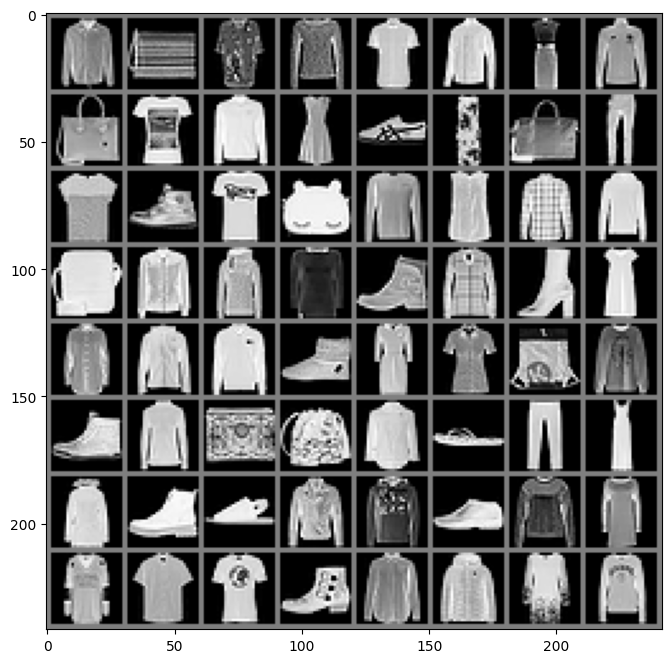

In [29]:
# Helper function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Explanation:
# - `img = img / 2 + 0.5` reverses the normalization to bring pixel values back to [0, 1] range for visualization.
# - `np.transpose(npimg, (1, 2, 0))` rearranges the image dimensions from (C, H, W) to (H, W, C) for displaying with matplotlib.

**Detailed Explanation:**

The line `img = img / 2 + 0.5` is used to **unnormalize** the image data for visualization purposes. During preprocessing, the images were normalized using a mean and standard deviation of 0.5, which scaled the pixel values to the range [-1, 1]. To display the images correctly, we need to transform the pixel values back to the range [0, 1]. Dividing by 2 and adding 0.5 effectively reverses the normalization process.

The line `plt.imshow(np.transpose(npimg, (1, 2, 0)))` rearranges the dimensions of the NumPy image array for proper display. PyTorch tensors have the shape (C, H, W), but `matplotlib` expects images in the shape (H, W, C). The `np.transpose` function swaps the axes so that the color channels are in the last dimension, ensuring that the image is displayed correctly with the appropriate colors.

## Define the CNN Model

The CNN includes:
- Two convolutional layers for feature extraction.
- Max pooling for dimensionality reduction.
- Fully connected layers for classification.

### Additional Insight:

- **Layer Details**:
  - `conv1`: Learns 32 filters of size 3x3.
  - `conv2`: Learns 64 filters of size 3x3.
  - **Activation Functions**: We use ReLU to introduce non-linearity.
  - **Flattening**: The output of the convolutional layers is flattened before entering the fully connected layers.
  - **Dropout (Improvement)**: We add dropout layers to prevent overfitting.

In [30]:
def to_device(*args, device):
    return [arg.to(device) for arg in args]


class CNN(nn.Module):
    __device: None
    def __init__(self, dropout=0.3, device=None):
        super(CNN, self).__init__()
        
        # Determine device
        self.__device = device or self.__get_device()
        self.to(self.__device)

        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)       # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 14x14 -> 14x14
        self.dropout = nn.Dropout(dropout)                                 # Regularization
        self.fc1 = nn.Linear(64 * 7 * 7, 512)                             # Fully connected
        self.fc2 = nn.Linear(512, 10)                                      # Output layer, 10 classes


    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
        x = self.dropout(x)        # Apply dropout
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def __get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Calculating the Number of Weights:**

To calculate the number of weights in a convolutional layer, you need to consider the size of the filters (kernels), the number of input channels, and the number of output channels. The formula for the number of weights in a convolutional layer is:

**Number of weights = (kernel_height * kernel_width * in_channels * out_channels) + out_channels**

The additional `out_channels` accounts for the bias term for each filter. For example, in the first convolutional layer `conv1`, we have 32 filters (`out_channels=32`), each of size 3x3 (`kernel_size=3`), and the input has 3 channels (`in_channels=3`). The number of weights is:

Number of weights = (3 * 3 * 3 * 32) + 32 = (27 * 32) + 32 = 864 + 32 = **896**


Calculating the number of weights helps in understanding the model's capacity and computational requirements.

## Visualizing Filters and Feature Maps

Understanding what the network learns at each layer helps demystify the "black box" nature of deep learning models.

### Visualizing Filters

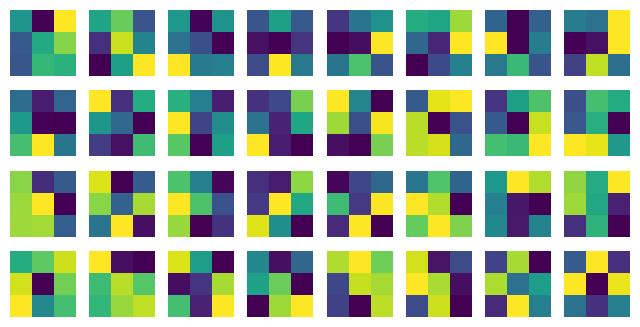

In [31]:
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    filters = filters - filters.min()
    filters = filters / filters.max()
    filter_num = filters.shape[0]
    n_columns = 8
    n_rows = filter_num // n_columns + (filter_num % n_columns > 0)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns, n_rows))
    for i in range(filter_num):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(filters[i].cpu().permute(1, 2, 0))
        axs[row, col].axis('off')
    plt.show()

# Visualize the filters of the first convolutional layer
model = CNN()
visualize_filters(model.conv1)

**Detailed Explanation:**

The `visualize_filters` function is designed to display the filters (kernels) learned by a convolutional layer in a neural network. The function takes a layer as input and accesses its weight data. It normalizes the weights to a 0-1 range by subtracting the minimum value and dividing by the maximum value, which is necessary for visual representation.

It then calculates the number of filters and organizes them into a grid for display using `matplotlib`. The filters are permuted to change their shape from `(channels, height, width)` to `(height, width, channels)` for proper visualization. The function iterates over each filter, placing them in the grid, and turns off the axis for clarity. Finally, it displays the filters, allowing us to inspect what features the network has learned to detect.

### Visualizing Feature Maps

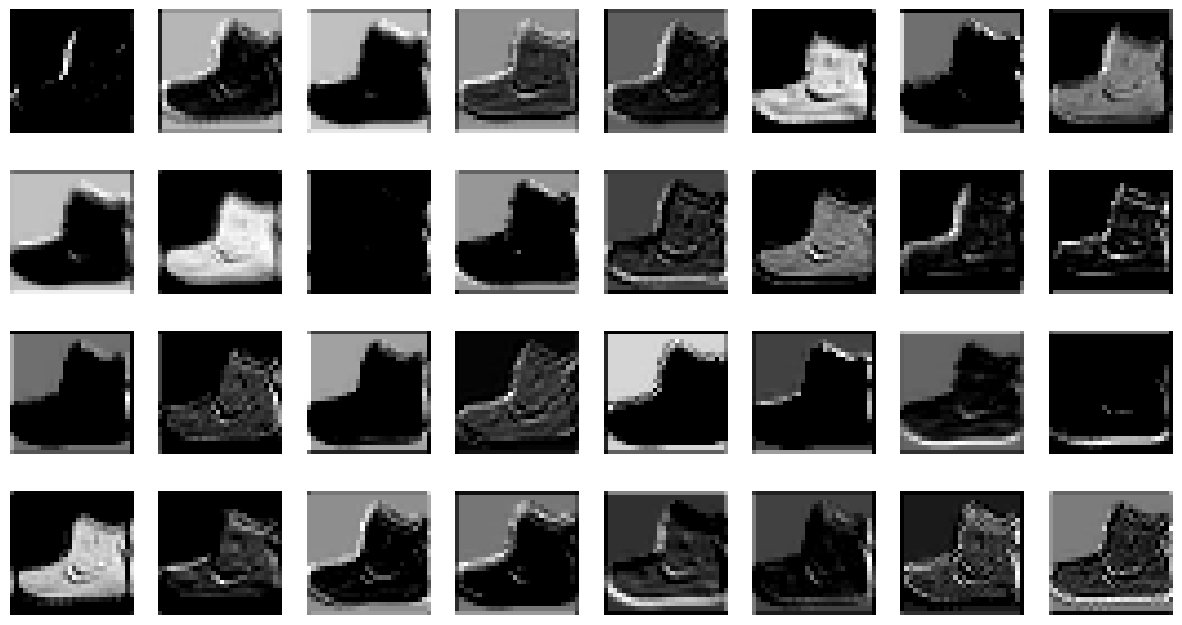

In [32]:
def visualize_feature_maps(image, model):
    x = image.unsqueeze(0)
    x = model.conv1(x)
    x = torch.relu(x)
    feature_maps = x.detach().squeeze(0)
    num_maps = feature_maps.shape[0]
    n_columns = 8
    n_rows = num_maps // n_columns + (num_maps % n_columns > 0)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
    for i in range(num_maps):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')
        axs[row, col].axis('off')
    plt.show()

# Visualize feature maps for a single image
sample_image, _ = train_dataset[0]
visualize_feature_maps(sample_image, model)

**Explanation:**
- **Filters**: Visualize the learned weights of convolutional layers.
- **Feature Maps**: Show the activation maps after applying the filters to an input image.
- The `x.detach()` function creates a tensor that is detached from the computation graph, which is necessary when we want to visualize the activations without tracking gradients.

## Training the Model

We define a training loop to update model weights using backpropagation.

### Improvements Made:

- **Learning Rate Adjustment**: We use a scheduler to reduce the learning rate if the validation loss plateaus.
- **Data Augmentation**: Added random horizontal flips to increase dataset variability.
- **Increased Epochs**: Training for more epochs to improve accuracy.

C:\Users\Zombiegg\AppData\Local\Temp\ipykernel_304508\2237319346.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


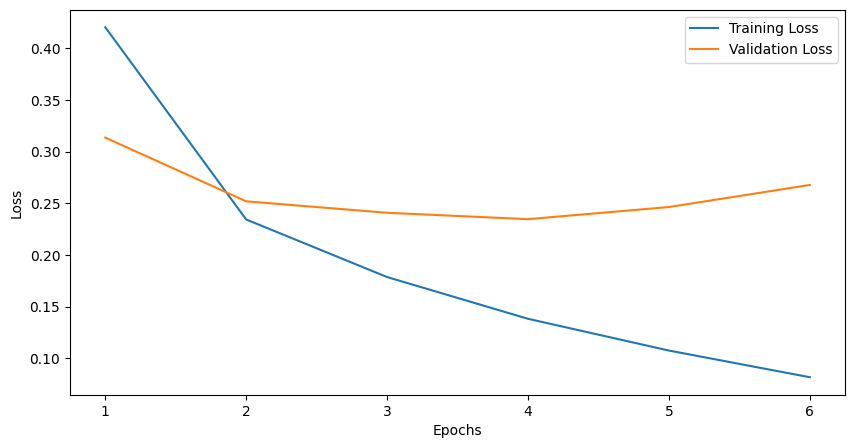

In [33]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

def train(model, criterion, optimizer, scheduler):
    train_losses = []
    val_losses = []
    epoch = 0
    for epoch in range(EPOCHS): # Training loop
        running_loss = 0.0
        model.train()
        for batch in train_loader:
            inputs, labels = to_device(*batch, device=device)
            optimizer.zero_grad()          # Reset gradients
            outputs = model(inputs)        # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()                # Backpropagation
            optimizer.step()             # Update weights
            running_loss += loss.item()

        # Validation phase
        if epoch % 2 == 0:
            train_loss = running_loss/len(train_loader)
            train_losses.append(train_loss)
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in test_loader:
                    inputs, labels = to_device(*batch, device=device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
            val_loss = val_loss / len(test_loader)
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        scheduler.step(val_loss)
    return epoch, train_losses, val_losses

def load(save_path):
    # Load the saved session
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_loss']
    val_losses = checkpoint['val_loss']
    return epoch, train_losses, val_losses

epoch = 0
train_losses = None
val_losses = None
if isfile(SAVE_PATH):
    epoch, train_losses, val_losses = load(SAVE_PATH)
else:
    epoch, train_losses, val_losses = train(model, criterion, optimizer, scheduler)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, int(EPOCHS / 2) + 1), train_losses, label='Training Loss')
plt.plot(range(1, int(EPOCHS / 2) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Explanation:
# - `model.train()` sets the model to training mode, enabling behaviors like dropout and batch normalization.
# - Added a learning rate scheduler to adjust learning rate during training.
# - Implemented data augmentation to improve generalization.

In [34]:
# save the results
if not isdir(SAVE_PATH_DIRECTORY):
    mkdir(SAVE_PATH_DIRECTORY)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'train_loss': train_losses,
    'val_loss': val_losses
}, SAVE_PATH)

**Detailed Explanation of `model.train()`:**

The `model.train()` method in PyTorch sets the model to training mode. This is important because certain layers, such as Dropout and BatchNorm, behave differently during training and evaluation. In training mode, Dropout layers randomly zero out some of the elements of the input tensor with a specified probability to prevent overfitting. BatchNorm layers compute and use batch statistics (mean and variance) to normalize the data.

By invoking `model.train()`, you ensure that these layers operate in their training configuration, which is essential during the training loop. Before evaluation or testing, you should set the model to evaluation mode using `model.eval()` to switch off certain behaviors like Dropout and to use running estimates in BatchNorm layers instead of batch statistics.

## Testing the Model

Evaluate the model's performance on unseen data.

In [35]:
# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
     for batch in test_loader:
        inputs, labels = to_device(*batch, device=device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 92.82%


## Confusion Matrix

To gain deeper insights into the model's performance, let's plot a confusion matrix.

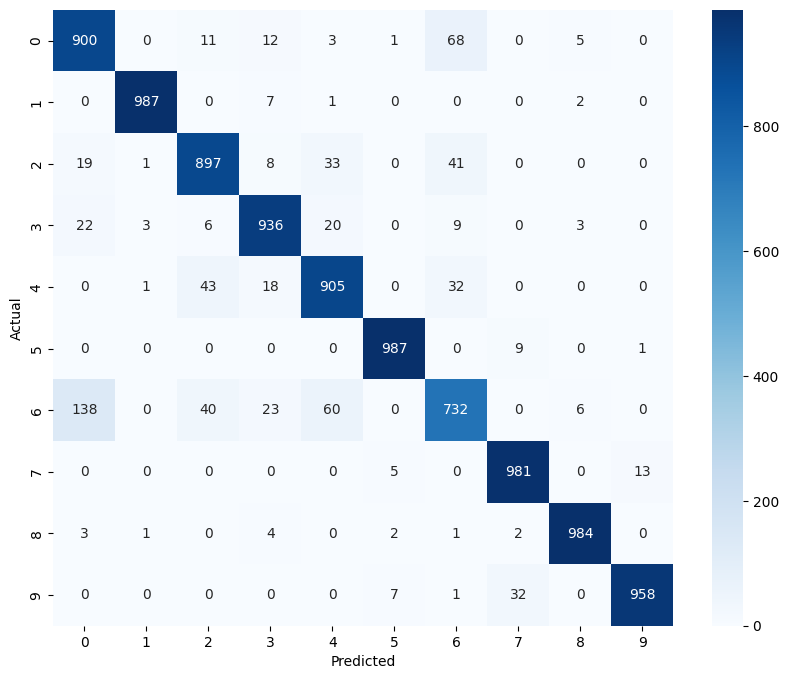

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Understanding Learned Features

### Visualizing Weights After Training

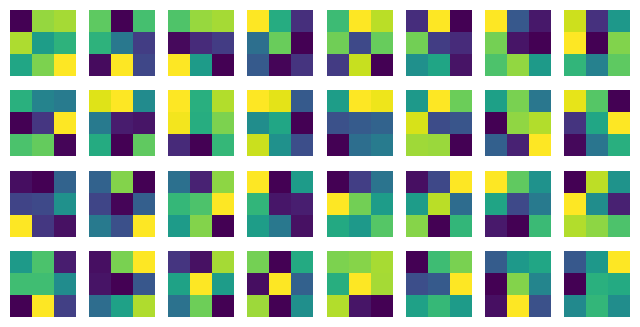

In [37]:
# Visualize the filters of the first convolutional layer after training
visualize_filters(model.conv1)

### Feature Maps at Different Layers

We can visualize how the input image is transformed as it passes through different layers.

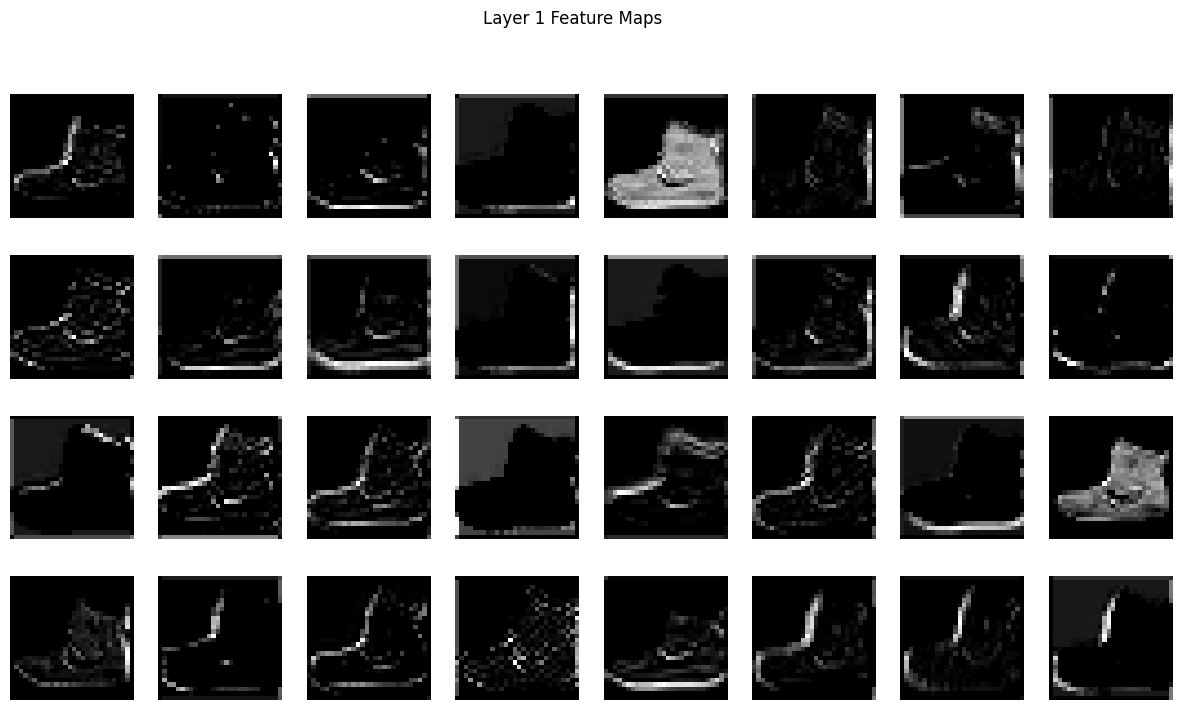

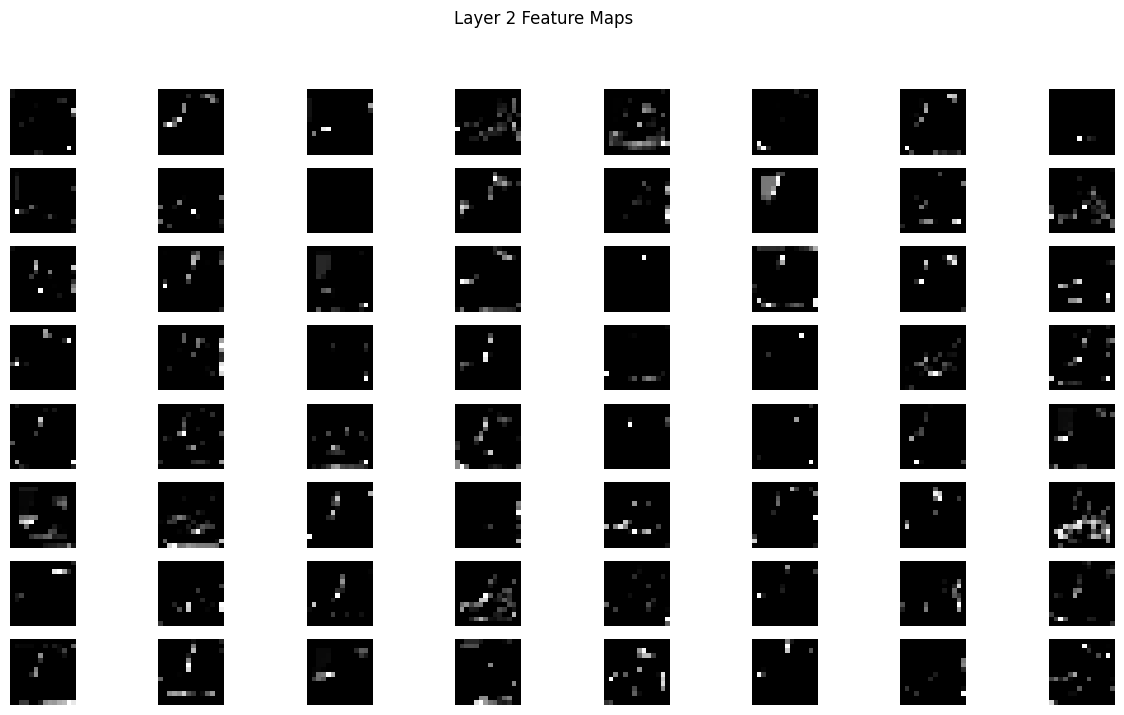

In [38]:
def visualize_intermediate_layers(image, model):
    model.to("cpu")
    activations = []
    x = image.unsqueeze(0)
    x = model.conv1(x)
    x = torch.relu(x)
    activations.append(x)
    x = model.pool(x)
    x = model.conv2(x)
    x = torch.relu(x)
    activations.append(x)
    x = model.pool(x)

    for idx, activation in enumerate(activations):
        feature_maps = activation.detach().squeeze(0)
        num_maps = feature_maps.shape[0]
        n_columns = 8
        n_rows = num_maps // n_columns + (num_maps % n_columns > 0)
        fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
        fig.suptitle(f'Layer {idx+1} Feature Maps')
        for i in range(min(num_maps, n_columns * n_rows)):
            row = i // n_columns
            col = i % n_columns
            axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')
            axs[row, col].axis('off')
        plt.show()
    model.to(device)
# Visualize feature maps at different layers
visualize_intermediate_layers(sample_image, model)

**Explanation:**
- **First Convolutional Layer**: Detects basic features like edges and textures.
- **Second Convolutional Layer**: Builds upon the first layer to detect more complex patterns.
- The `x.detach()` function creates a tensor that is detached from the computation graph, which is necessary when we want to visualize the activations without tracking gradients.

## Hyperparameter Tuning with GridSearchCV

To fine-tune the hyperparameters of our CNN model, we can use `GridSearchCV` from `scikit-learn`. However, since `GridSearchCV` doesn't directly support PyTorch models, we'll use the `skorch` library, which provides a scikit-learn compatible wrapper for PyTorch models.

In [ ]:
# Define the skorch neural net classifier
net = NeuralNetClassifier(
    CNN,
    max_epochs=10,
    lr=0.01,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device=device
)

# Prepare the data
X = [data[0].numpy() for data in train_dataset]
y = [data[1] for data in train_dataset]

# Define the parameter grid
params = {
    'lr': [0.01, 0.001],
    'max_epochs': [5, 10],
    'module__dropout': [0.3, 0.5],
    'optimizer': [optim.Adam, optim.SGD],
    'optimizer__weight_decay': [0, 0.0001]
}

# Perform Grid Search
gs = GridSearchCV(net, params, refit=True, cv=3, scoring='accuracy')

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)
print("starting search")
gs.fit(X, y)

# Print the best score and parameters
print('Best score:', gs.best_score_)
print('Best params:', gs.best_params_)

# Use the best model
best_net = gs.best_estimator_
# Best params: {'lr': 0.001, 'max_epochs': 10, 'module__dropout': 0.5, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__weight_decay': 0}

# Test the best model on test data
X_test = [data[0].numpy() for data in test_dataset]
y_test = [data[1] for data in test_dataset]
X_test = np.array(X_test)
y_test = np.array(y_test)

test_acc = best_net.score(X_test, y_test)
print('Test Accuracy:', test_acc)
# Best score: 0.9001870128451889
# Best params: {'lr': 0.001, 'max_epochs': 10, 'module__dropout': 0.5, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__weight_decay': 0}
# Test Accuracy: 0.9064612784265519

KeyboardInterrupt: 

: 

**Explanation:**
- We use `skorch.NeuralNetClassifier` to wrap our PyTorch model.
- Define a parameter grid with hyperparameters to tune.
- Use `GridSearchCV` to find the best combination of hyperparameters.
- Evaluate the best model on the test dataset.

## Data Augmentation with RandomHorizontalFlip

The `transforms.RandomHorizontalFlip()` applies a horizontal flip to the input image with a default probability of 0.5. This means that, on average, half of the images will be flipped horizontally during training. This operation is a form of data augmentation, which increases the diversity of the training data without actually adding new records.

However, it does not add additional records to the dataset; instead, it transforms the existing images on-the-fly during training. Each epoch may see different augmented versions of the images due to the random nature of the transformation. This helps the model generalize better by learning invariant features to such transformations.